# PDE Constrained Optimisation with G-ADOPT
## Example: Inversion for Initial Condition with given Final State

In this tutorial example we will see how we can use the PDE constrained optimisation functionality of G-ADOPT/Firedrake to optimize one of the inputs to a PDE for a specified desired outcome. We will use a time-dependent advection-diffussion equation as our PDE and see how, for a given final state of the solution we can retrieve what the initial condition should be.

In [1]:
# Load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://github.com/g-adopt/tutorials/releases/latest/download/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

The usual imports, except we also import the inverse module of gadopt `gadopt.inverse`, which provides
the interface to the inversion functionality we need, but also switches
on the "tape" which automatically registers all operations that form
part of the forward model, which is used to automatically form the adjoint (backward) model.

In [2]:
# Usual imports
import matplotlib.pyplot as plt
import numpy as np
from gadopt import *
# Starts the tape
from gadopt.inverse import *

## Create Synthetic Twin Experiment With Final State for a Known Initial Condition
We first run a advection-diffusion model with known initial condition. Of that model we only store the solution at the final timestep, which we will use in our inversion experiment later on as the target final state.

Setup of the model, with mesh, functionspaces, prescribed velocity field, boundary conditions, etc. We use the `EnergySolver` of G-ADOPT to set up an energy equation in the Boussinesq Approximation, which is just a scalar advection-diffusion equation for temperature.

In [3]:
mesh = UnitSquareMesh(20, 20)
left, right, bottom, top = 1, 2, 3, 4  # Boundary IDs

V = VectorFunctionSpace(mesh, "CG", 2)  # function space for velocity
Q = FunctionSpace(mesh, "CG", 1)  # function space for the scalar (Temperature)
T = Function(Q, name='Temperature')

# set up velocity field: anti-clockwise rotation around (0.5, 0.5)
x, y = SpatialCoordinate(mesh)
u = interpolate(as_vector((-y+0.5, x-0.5)), V)
u.rename('Velocity')

# Rayleigh number Ra is not actually used here, kappa is the diffusivity
approximation = BoussinesqApproximation(Ra=1, kappa=1e-2)
temp_bcs = {}  # all closed boundaries by default
delta_t = .1  # timestep
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

Setup the initial condition: a Gaussian at $(0.75, 0.5)$. This will be the initial condition we will try to invert for later on.

In [4]:
x0, y0 = 0.75, 0.5
w = .1
r2 = (x-x0)**2 + (y-y0)**2
T.interpolate(exp(-r2/w**2));

A little plotting helper function to plot the Temperature with specified upper bound for the colour scale.

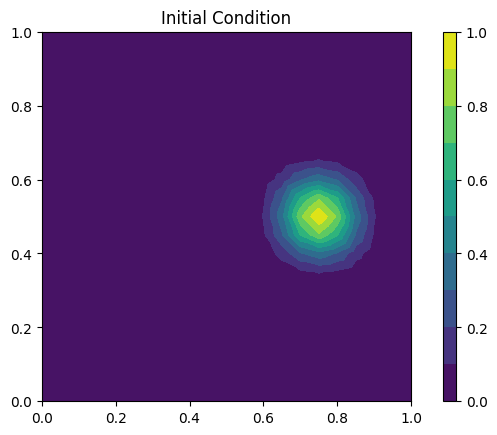

In [5]:
def plot_temp(T, title=None, Tmax=1, ax=None, colorbar=True):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    levels = np.linspace(0, Tmax, 11)
    # this tells the tape to *not* register the interpolation that happens inside the plotting script
    with stop_annotating():
       c = tricontourf(T, axes=ax, levels=levels)
    ax.set_title(title)
    ax.set_aspect('equal')
    if colorbar:
        cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().y1-ax.get_position().y0])
        fig.colorbar(c, cax=cax)
plot_temp(T, 'Initial Condition', Tmax=1)

The actual model: ten timesteps. Pretty simple, huh?

In [6]:
for i in range(10):
    energy_solver.solve()

  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1


Plot the final temperature solution and save it in a checkpoint file.

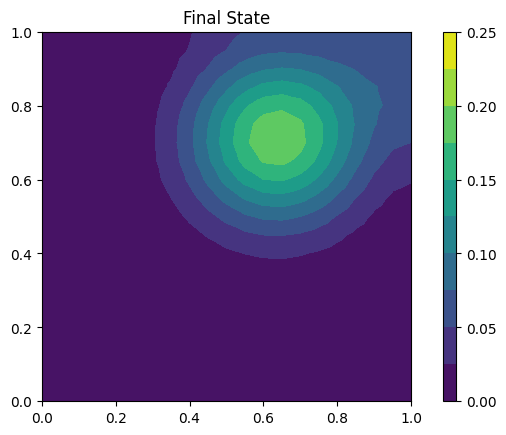

In [7]:
plot_temp(T, 'Final State', Tmax=0.25)
with CheckpointFile('final.h5', 'w') as f:
    f.save_mesh(mesh)
    f.save_function(T)

## Advection Diffusion Model with Unknown Initial Condition
We now start completely from scratch again with an advection-diffusion model with the same configuration, except this time
we don't know the correct initial condition. As we want to measure for different initial conditions, how well the final state of the model matches the one we just saved, we first read back that target final state. We will also use the mesh from the checkpoint file to construct the model.

In [8]:
with CheckpointFile('final.h5', 'r') as f:
    mesh = f.load_mesh()
    T_target = f.load_function(mesh, 'Temperature')

Setup exactly as before:

In [9]:
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
T = Function(Q, name='Temperature')

x, y = SpatialCoordinate(mesh)
u = interpolate(as_vector((-y+0.5, x-0.5)), V)
u.rename('Velocity')

approximation = BoussinesqApproximation(Ra=1, kappa=1e-2)
temp_bcs = {}  # all closed boundaries by default
delta_t = .1
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

This time however, we don't want to use the known initial condition. Instead we will start with the final state from our last model, which will then be further rotated and diffused. After again ten timesteps we compute the mismatch between the new final state, and the checkpointed final state. This computation, the ten timesteps and the mismatch calculation, forms the forward model that we want to invert. Its adjoint will be created automatically from the tape that registers all operations in the model. Since the tape was automatically started at the top when we imported `gadopt.inverse`, we want to make sure we don't get mixed up with any operations that happened in our initial twin model, so we first clear everything that has already been registered off the tape.

In [10]:
tape = get_working_tape()
tape.clear_tape()

T.interpolate(T_target)

# we want to vary the _initial_ (current) state of T
# here we specify the current state of T as the control
m = Control(T)

for i in range(10):
    energy_solver.solve()

# For good performance of optimisation algorithms, it is important to
# scale both the control and the functional values to be of order 1
# Note that mathematically scaling the functional should not change the optimal solution
scaling = 1./assemble(T_target**2*dx)
J = assemble(scaling * (T-T_target)**2*dx)
print(f"Mismatch functional J={J:.14f}")

  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
Mismatch f

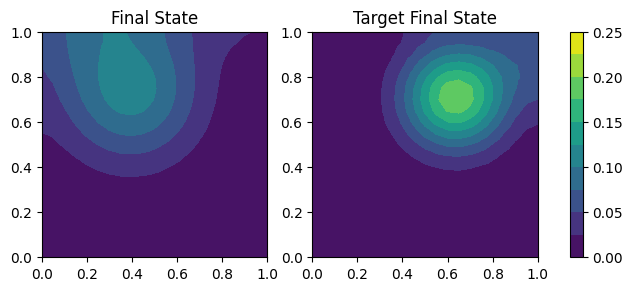

In [11]:
fig, ax = plt.subplots(1,2)
plot_temp(T, 'Final State', Tmax=.25, ax=ax[0], colorbar=False)
plot_temp(T_target, 'Target Final State', Tmax=.25, ax=ax[1])

Now we have run the forward model including the calculation of the forward model, we can define the *reduced functional* which combines the functional with the control we specified above:

In [12]:
Jhat = ReducedFunctional(J, m)

The reduced functional allows us to rerun the forward model for different values of the control. It can be used as a function that takes in any choice of the control, runs the forward model and computes the functional. For instance we can rerun the model again using `T_target` as the initial condition, i.e. rerunnnig the exact same model we have just run:

In [13]:
print(f"{Jhat(T_target):.14f}")

  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
0.69164013

As expected it produces the exact same functional value. Now we can try to see what happens if we use the correct initial condition, that we have used in our twin experiment:

In [14]:
x0, y0 = 0.75, 0.5
w = .1
r2 = (x-x0)**2 + (y-y0)**2
T0 = interpolate(exp(-r2/w**2), Q)

In [15]:
print(Jhat(T0))

  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
0.0


Using the "correct" initial condition, we reach the same final state as in our twin model, and thus the functional ends up being exactly zero!

In addition to rerunning the model by evaluating the reduced functional, we can also calculate its derivative. This computes the sensitivity of the model with respect to its control (the initial condition). Here it tells us in what locations a (small) increase in the initial condition will lead to an increase in the functional.

  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
Linear Imp

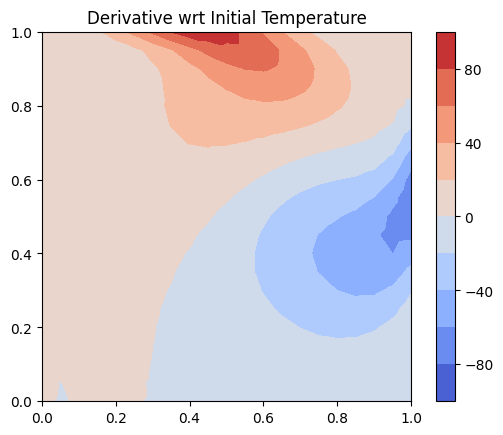

In [16]:
# we want to compute the derivative at the "wrong" initial condition T_target
# so we first rerun the forward model with that value for the control
Jhat(T_target)

# ask for L2 Riesz representation to get grid-independent result
gradJ = Jhat.derivative(options={"riesz_representation": "L2"})

fig, ax = plt.subplots()
levels = np.linspace(-100, 100, 11)
from matplotlib import colors
cmap = plt.cm.coolwarm
with stop_annotating():
    c = tricontourf(gradJ, axes=ax, levels=levels, norm=colors.CenteredNorm(), cmap=cmap)
ax.set_title('Derivative wrt Initial Temperature')
ax.set_aspect('equal')
fig.colorbar(c);

## Invert for Optimal Initial Condition Using Gradient-Based Optimisation Algorithm
We now have all the ingredients:
- the ability to rerun and re-evaluate the functional for arbitrary input control values,
- compute the derivative of the functional with respect to that control,
that are needed to perform an inversion for the initial condition using a gradient based optimisation algorithm.

To keep things simple, we here use the "L-BFGS-B" algorithm as it is implemented in scipy. The `minimize()` function that is exported by `gadopt.inverse` provides a wrapper around [scipy's minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to translate between G-ADOPT/Firedrake objects and numpy arrays. G-ADOPT also provides an interface to the [ROL optimisation library](https://trilinos.github.io/) library, which we generally recommend over the scipy interface.

In [17]:
# the L-BFGS-B allows for "box constraints", min and max values for the control
# which we can provide as functions in the same functionspace as the control
Tmin = Function(Q)  # Tmin is not initialised, so remains as a zero lower bound for the control
Tmax = Function(Q)
Tmax.assign(1)  # upper bound of 1

# select L-BFGS-B as the method and provide bounds
# the tolerance is an absolute tolerance on the norm of the gradient which should be reduced to near zero
# minimize() returns the found optimal control, i.e. best fit initial condition
T_opt = minimize(Jhat, method='L-BFGS-B', bounds=[Tmin, Tmax], tol=1e-5)

/home/skramer/firedrake/src/firedrake/firedrake/adjoint_utils/function.py:112: UserWarning: Could not find overloaded class of type '<class 'int'>'.
  other = create_overloaded_object(other)


  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
Linear Imp

Let's see how well we have done:

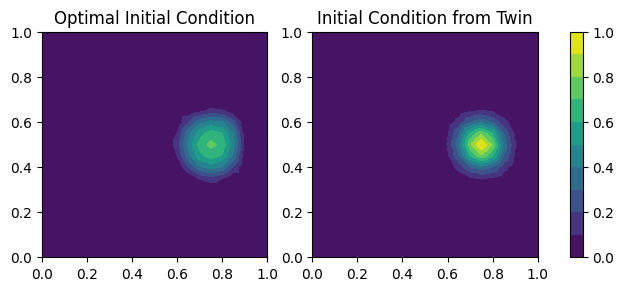

In [18]:
fig, ax = plt.subplots(1,2)
plot_temp(T_opt, 'Optimal Initial Condition', Tmax=1, ax=ax[0], colorbar=False)
plot_temp(T0, 'Initial Condition from Twin', Tmax=1, ax=ax[1])